# Info

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries Import

In [93]:
import tqdm
import kagglehub

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

In [95]:
import os
from collections import Counter
import random
import re
import json
import pickle
from collections import Counter
import math

In [96]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.preprocessing import LabelEncoder

# Constants

In [98]:
BASE_DIR = r'drive/MyDrive/chatbot_answerrr'
# BASE_DIR = ''

In [99]:
EPOCHS = 20
BATCH_SIZE = 1024

In [100]:
SENTENCE_MAX_WORDS_LEN = 12
OOV_TOKEN = '<OOV>'
EMBEDDING_DIM = 64

In [101]:
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

In [102]:
RONDOM_STATE = 42
np.random.seed(RONDOM_STATE)

In [103]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'train_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [104]:
LOGGING_DIR_NAME = os.path.join(BASE_DIR, 'logging')
os.makedirs(LOGGING_DIR_NAME, exist_ok=True)

TOKENIZER_WORDS_PATH = os.path.join(LOGGING_DIR_NAME, 'tokenizer_index_word_sample.json')

In [105]:
DEPLOYMENST_PATH = os.path.join(BASE_DIR, 'deployments')
os.makedirs(DEPLOYMENST_PATH, exist_ok=True)

TOKENIZER_PATH = os.path.join(DEPLOYMENST_PATH, 'tokenizer.pkl')

# Functions

In [106]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [107]:
def save_obj_json(obj, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=4)

def load_obj_json(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        return json.load(f)

In [108]:
def count_words_in_sentence(sentence):
    words = str(sentence).split(" ")
    words = list(filter(lambda x: x.strip() != "", words))
    return len(words)

# Dataset Read

In [109]:
DATA_PATH = os.listdir('data')
DATA_JSON_PATHS = [os.path.join('data', f) for f in DATA_PATH if f.endswith('.json')]
DATA_JSON_PATHS = sorted(DATA_JSON_PATHS)

data_entries = []

for data_json_path in tqdm.tqdm(DATA_JSON_PATHS):
    data_json = load_obj_json(data_json_path)

    for intent in  data_json.get('intents'):
        tag_i = intent.get('tag')
        patterns_i = intent.get('patterns')
        responses_i = intent.get('responses')

        for pattern in patterns_i:
            for response in responses_i:
                data_entries.append({
                    'tag': str(tag_i),
                    'pattern': str(pattern),
                    'response': str(response)
                })

100%|██████████| 6/6 [00:00<00:00, 317.61it/s]


In [110]:
data_df = pd.DataFrame(data_entries)
del data_entries

# Exploration

In [111]:
pd.concat([
    data_df.head(2),
    data_df.sample(5),
    data_df.tail(2)
])

,tag,pattern,response
0,greeting,Hi,Hey there!
1,greeting,Hi,Hello! How can I assist you?
555,queues,Explain queues in computer programming.,A queue is a linear data structure that follow...
1420,History,Recommend a History book,{'Book': 'Presidential Power and the Modern Pr...
1656,greeting,What's up,"Hello, there."
650,software_process_models,What are Software Process Models?,Software Process Models are abstract represent...
1442,Literary Criticism,Literary Criticism,"{'Book': 'The Writing Life', 'Feedback': 'Anni..."
2328,stories,Can you tell me a story.,It would be too long for me to speak.
2329,stories,Can you tell me a story.,You would get bored if I do so.


In [112]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag       2330 non-null   object
 1   pattern   2330 non-null   object
 2   response  2330 non-null   object
dtypes: object(3)
memory usage: 54.7+ KB


In [113]:
data_df.describe(include='all')

,tag,pattern,response
count,2330,2330,2330
unique,302,1112,516
top,greeting,Hello,"Hi there, how can I help?"
freq,211,28,28


In [114]:
print(f"Total samples: {len(data_df)}")

Total samples: 2330


# Visualization

In [115]:
plt.style.use(plt.style.available[12])

In [116]:
data_df['pattern_words_count'] = data_df['pattern'].apply(count_words_in_sentence)

<Axes: title={'center': 'Distribution of Count words in patterns'}, xlabel='pattern_words_count', ylabel='Count'>

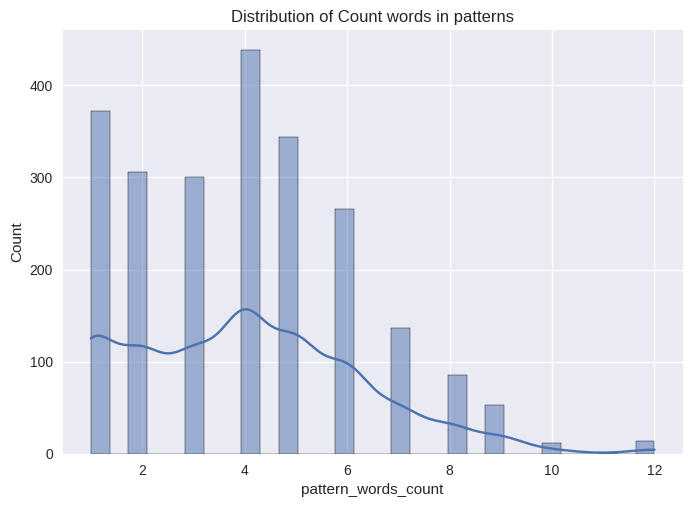

In [117]:
plt.title('Distribution of Count words in patterns')
sns.histplot(data=data_df, x='pattern_words_count', bins=30, kde=True)

In [118]:
print("Unique tags:", data_df['tag'].nunique())
print(data_df['tag'].value_counts())

Unique tags: 302
tag
greeting    211
goodbye     182
thanks      125
Menu        100
hepl        100
           ... 
testing       1
lr            1
dll           1
dt            1
bst           1
Name: count, Length: 302, dtype: int64


# Preprocessing

Null values

In [119]:
print(f"N Nulls before: {data_df.isnull().sum().sum()}")

N Nulls before: 0


In [120]:
data_df.dropna(inplace=True)

In [121]:
print(f"N Nulls after: {data_df.isnull().sum().sum()}")

N Nulls after: 0


Regex

In [122]:
def process_tag(label):
    label = str(label).lower().strip()
    label = re.sub(r'[^A-Za-z]', ' ', label)
    label = re.sub(r'\s+', ' ', label).strip()
    return label

In [123]:
data_df['tag'] = data_df['tag'].apply(process_tag)

In [124]:
def process_pattern(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^A-Za-z0-9]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Separate letters and digits, e.g., "Room101" -> "Room 101"
    text = re.sub(r'([A-Za-z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [125]:
data_df['pattern'] = data_df['pattern'].apply(process_pattern)

Duplicates

In [126]:
print("N Duplicates before:", data_df.duplicated().sum())

N Duplicates before: 31


In [127]:
data_df.drop_duplicates(inplace=True)

In [128]:
print("N Duplicates after:", data_df.duplicated().sum())

N Duplicates after: 0


Drop too long patterns

In [129]:
print("Number of samples before:", len(data_df))

data_df['pattern_words_count'] = data_df['pattern'].apply(count_words_in_sentence)
data_df = data_df[ data_df['pattern_words_count'] <= SENTENCE_MAX_WORDS_LEN ]

print("Number of samples after:", len(data_df))

Number of samples before: 2299
Number of samples after: 2299


Remove any tags has few numbers of samples

In [130]:
print(f"Total Tags Before: {data_df['tag'].nunique()}")

Total Tags Before: 300


In [131]:
unqiue_tags = data_df['tag'].value_counts()

for tag_i, freq_i in unqiue_tags.items():
    if freq_i < 3:
        print(f"Removing tag: {tag_i} with freq: {freq_i}")
        data_df = data_df[data_df['tag'] != tag_i]

Removing tag: universal quantification with freq: 2
Removing tag: one dimensional arrays with freq: 2
Removing tag: existential quantification with freq: 2
Removing tag: rate of growth of complexity of algorithms with freq: 2
Removing tag: asymptotic notations with freq: 2
Removing tag: time space trade offs with freq: 2
Removing tag: operations on strings with freq: 2
Removing tag: word processing with freq: 2
Removing tag: pattern matching algorithms with freq: 2
Removing tag: oop with freq: 2
Removing tag: data abstraction with freq: 2
Removing tag: objects classes and methods with freq: 2
Removing tag: constructors with freq: 2
Removing tag: destructors with freq: 2
Removing tag: operator overloading with freq: 2
Removing tag: generic programming with freq: 2
Removing tag: inheritance with freq: 2
Removing tag: multiple inheritance with freq: 2
Removing tag: polymorphism with freq: 2
Removing tag: aggregation with freq: 2
Removing tag: program debugging and testing with freq: 2
Rem

In [132]:
print(f"Total Tags After: {data_df['tag'].nunique()}")

Total Tags After: 147


Final

In [133]:
data_df.reset_index(drop=True, inplace=True)

In [134]:
pd.concat([
    data_df.head(2),
    data_df.sample(5),
    data_df.tail(2)
])

,tag,pattern,response,pattern_words_count
0,greeting,hi,Hey there!,1
1,greeting,hi,Hello! How can I assist you?,1
1572,thanks,amazing,It was the least I could do!,1
17,greeting,howdy,Hello! Hope you're having a great day!,1
41,weather,tell me the current weather,The weather is sunny and warm today.,5
55,weather,is it going to rain,Expect a mix of sun and clouds with a chance o...,5
705,hostel,hostel fees,"For hostel detail visit <a target=""_blank"" hre...",2
2011,stories,can you tell me a story,It would be too long for me to speak.,6
2012,stories,can you tell me a story,You would get bored if I do so.,6


# Corpus Extraction

In [135]:
X = data_df['pattern'].values
y_str = data_df['tag'].values

Label Encoder

In [136]:
class_freq_pairs = list(Counter(y_str).items())

class_freq_pairs.sort(key=lambda x: x[1], reverse=True)
class_freq_pairs[0:5]

[('greeting', 199),
 ('goodbye', 179),
 ('thanks', 125),
 ('menu', 107),
 ('hepl', 100)]

In [137]:
y_label_encoder = LabelEncoder()

#store most frequent classes first
y_label_encoder.classes_ = np.array([x[0] for x in class_freq_pairs])

y_encoded = y_label_encoder.transform(y_str)

Tokenizer

In [138]:
if os.path.exists(TOKENIZER_PATH):
    print("📂 Loading tokenizer from cache...")
    x_tokenizer = load_obj(TOKENIZER_PATH)

else:
    print("⚙️ Creating new tokenizer...")
    x_tokenizer = Tokenizer(
        num_words=None,
        filters='',
        lower=None,
        split=' ',
        oov_token=OOV_TOKEN,
        char_level=False
    )

    x_tokenizer.fit_on_texts(
        X
    )

⚙️ Creating new tokenizer...


In [139]:
print("N Words in vocabulary:", len(x_tokenizer.word_index))

N Words in vocabulary: 687


In [140]:
save_obj_json(x_tokenizer.index_word, TOKENIZER_WORDS_PATH)

In [141]:
X = x_tokenizer.texts_to_sequences(X)

Pad Sequence

In [142]:
X = pad_sequences(X, maxlen=SENTENCE_MAX_WORDS_LEN, padding='post', truncating='post')

In [143]:
print("Sample: ", X[124])
print("Shape: ", X.shape)

Sample:  [21  7  3 40  0  0  0  0  0  0  0  0]
Shape:  (2013, 12)


# Data Split

In [144]:
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SPLIT + VAL_SPLIT,
    random_state=RONDOM_STATE,
)

X_test, X_val, y_encoded_test, y_encoded_val = train_test_split(
    X_test, y_encoded_test,
    test_size=VAL_SPLIT / (TEST_SPLIT + VAL_SPLIT),
    random_state=RONDOM_STATE,
)

print(f"{X_train.shape = }")
print(f"{X_val.shape = }")
print(f"{X_test.shape = }")

print(f"{y_encoded_train.shape = }")
print(f"{y_encoded_val.shape = }")
print(f"{y_encoded_test.shape = }")

X_train.shape = (1207, 12)
X_val.shape = (403, 12)
X_test.shape = (403, 12)
y_encoded_train.shape = (1207,)
y_encoded_val.shape = (403,)
y_encoded_test.shape = (403,)


# Data Generators

## Siamese

In [145]:
class MyDataGeneratorSiamesePair(Sequence):
    def __init__(self, X, y, batch_size=32, feature_extractor_model=None, shuffle=True, hard_negative_prob=0.8):
        self.X = np.array(X)
        self.y = np.array(y)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.hard_negative_prob = hard_negative_prob

        self.feature_extractor_model = feature_extractor_model
        self.embeddings = None
        self.dist_matrix = None

        self.on_epoch_end()

    def __len__(self):
        """Approximate number of batches per epoch."""
        return int(np.ceil(len(self.X) ** 2 / self.batch_size))

    def __getitem__(self, idx):
        """Return one batch of pairs."""
        x1, x2, labels = self._generate_pairs(self.batch_size)
        return (x1, x2), np.array(labels)

    def on_epoch_end(self):
        """Shuffle data and refresh embeddings if extractor is available."""
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)
            self.X = self.X[self.indices]
            self.y = self.y[self.indices]

        # If a feature extractor exists, recompute embeddings and distances
        if self.feature_extractor_model is not None:
            self.embeddings = self.feature_extractor_model.predict(self.X, verbose=0)
            # Normalize embeddings (optional, for cosine-like distance)
            self.embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
            # Pairwise distance matrix
            self.dist_matrix = np.linalg.norm(
                self.embeddings[:, None, :] - self.embeddings[None, :, :],
                axis=-1
            )

    def set_feature_extractor(self, model):
        """Setter for external feature extractor model."""
        self.feature_extractor_model = model
        self.embeddings = None
        self.dist_matrix = None

    def _generate_pairs(self, batch_size):
        """Generate pairs of samples (positive & negative)."""
        batch_x1, batch_x2, batch_labels = [], [], []

        for _ in range(batch_size):
            idx1 = np.random.randint(0, len(self.X))
            label1 = self.y[idx1]

            if np.random.rand() > 0.5:
                # Positive pair
                candidates = np.where(self.y == label1)[0]
                idx2 = np.random.choice(candidates)
                label = 1
            else:
                # Negative pair
                candidates = np.where(self.y != label1)[0]

                if self.feature_extractor_model is not None and self.dist_matrix is not None:
                    if np.random.rand() < self.hard_negative_prob:
                        # Hardest negative (closest embedding but different class)
                        dists = self.dist_matrix[idx1, candidates]
                        idx2 = candidates[np.argmin(dists)]
                    else:
                        # Random negative
                        idx2 = np.random.choice(candidates)
                else:
                    # No extractor → random negative
                    idx2 = np.random.choice(candidates)

                label = 0

            batch_x1.append(self.X[idx1])
            batch_x2.append(self.X[idx2])
            batch_labels.append(label)

        return np.array(batch_x1), np.array(batch_x2), batch_labels

In [146]:
train_siamese_generator = MyDataGeneratorSiamesePair(X_train, y_encoded_train,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)

val_siamese_generator = MyDataGeneratorSiamesePair(X_val, y_encoded_val,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

test_siamese_generator = MyDataGeneratorSiamesePair(X_test, y_encoded_test,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False)

In [147]:
N_ROWS = 10
COUNTER_i = 0

(batch_x1, batch_x2), batch_y = train_siamese_generator[0]

for x1, x2, y in zip(batch_x1, batch_x2, batch_y):
    if COUNTER_i >= N_ROWS:
        break
    else:
        COUNTER_i += 1

    print(f"Pair {COUNTER_i}:")
    print(" Sentence 1:", " ".join([x_tokenizer.index_word.get(idx, '') for idx in x1 if idx > 0]))
    print(" Sentence 2:", " ".join([x_tokenizer.index_word.get(idx, '') for idx in x2 if idx > 0]))
    print("  Similarity:", "Similar" if y == 1 else "Not Similar")
    print('-' * 20)

Pair 1:
 Sentence 1: how s your day
 Sentence 2: got any plans for the weekend
  Similarity: Similar
--------------------
Pair 2:
 Sentence 1: recommend a book in music
 Sentence 2: recommend a book in literary criticism
  Similarity: Not Similar
--------------------
Pair 3:
 Sentence 1: the mouse is dead
 Sentence 2: mouse issues
  Similarity: Similar
--------------------
Pair 4:
 Sentence 1: do you serve drinks
 Sentence 2: have a great day
  Similarity: Not Similar
--------------------
Pair 5:
 Sentence 1: thanks
 Sentence 2: any joke for me
  Similarity: Not Similar
--------------------
Pair 6:
 Sentence 1: recommend me something to read
 Sentence 2: which jedi can help me in this mission
  Similarity: Not Similar
--------------------
Pair 7:
 Sentence 1: mouse issues
 Sentence 2: what are the thing you can do
  Similarity: Not Similar
--------------------
Pair 8:
 Sentence 1: computer engineering
 Sentence 2: recommend a book in american fiction
  Similarity: Not Similar
---------

## Triplet

In [148]:
class MyDataGeneratorTriplet(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, hard_negative_prob=0.8):
        self.X = np.array(X)
        self.y = np.array(y)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.hard_negative_prob = hard_negative_prob

        self.feature_extractor = None   # external model (can be set later)
        self.embeddings = None          # cached embeddings
        self.dist_matrix = None         # cached distance matrix

        self.on_epoch_end()

    def set_feature_extractor(self, model):
        """Setter for external feature extractor model."""
        self.feature_extractor = model
        self.embeddings = None
        self.dist_matrix = None

    def __len__(self):
        """Approximate number of batches per epoch."""
        return int(np.ceil(len(self.X) ** 2 / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of triplets."""
        batch_a, batch_p, batch_n, batch_labels = self._generate_triplets(self.batch_size)
        return (batch_a, batch_p, batch_n), batch_labels

    def on_epoch_end(self):
        """Shuffle dataset and recompute embeddings if feature extractor is available."""
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)
            self.X = self.X[self.indices]
            self.y = self.y[self.indices]

        # If a feature extractor is available, compute embeddings and distances
        if self.feature_extractor is not None:
            self.embeddings = self.feature_extractor.predict(self.X, verbose=0)
            # Normalize embeddings (optional but useful for cosine distance)
            self.embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
            # Compute distance matrix (symmetric, NxN)
            self.dist_matrix = np.linalg.norm(
                self.embeddings[:, None, :] - self.embeddings[None, :, :],
                axis=-1
            )

    def _generate_triplets(self, batch_size):
        """Generate a batch of triplets with optional hard negative mining."""
        batch_a, batch_p, batch_n, batch_labels = [], [], [], []
        classes = np.unique(self.y)

        for _ in range(batch_size):
            # Choose anchor class and negative class
            anchor_class, negative_class = np.random.choice(classes, 2, replace=False)

            # Anchor and Positive
            pos_candidates = np.where(self.y == anchor_class)[0]
            anchor_idx, pos_idx = np.random.choice(pos_candidates, 2, replace=True)

            # Negative (random vs hard)
            neg_candidates = np.where(self.y == negative_class)[0]

            if self.feature_extractor is not None and self.dist_matrix is not None:
                if np.random.rand() < self.hard_negative_prob:
                    # Pick hardest negative = min distance among neg_candidates
                    dists = self.dist_matrix[anchor_idx, neg_candidates]
                    neg_idx = neg_candidates[np.argmin(dists)]
                else:
                    # Fallback: random negative
                    neg_idx = np.random.choice(neg_candidates)
            else:
                # No extractor: random negative
                neg_idx = np.random.choice(neg_candidates)

            # Append triplet
            batch_a.append(self.X[anchor_idx])
            batch_p.append(self.X[pos_idx])
            batch_n.append(self.X[neg_idx])
            batch_labels.append(0)  # Dummy label

        return (
            np.array(batch_a),
            np.array(batch_p),
            np.array(batch_n),
            np.array(batch_labels),
        )


In [149]:
train_triplet_generator = MyDataGeneratorTriplet(X_train, y_encoded_train,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)

val_triplet_generator = MyDataGeneratorTriplet(X_val, y_encoded_val,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

test_triplet_generator = MyDataGeneratorTriplet(X_test, y_encoded_test,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False)

In [150]:
N_ROWS = 10
COUNTER_i = 0

(batch_a, batch_p, batch_n), batch_y = train_triplet_generator[0]

for a_i, p_i, n_i, y in zip(batch_a, batch_p, batch_n, batch_y):
    if COUNTER_i >= N_ROWS:
        break
    else:
        COUNTER_i += 1

    print(f"Triplet {COUNTER_i}:")
    print(" Anchor:", " ".join([x_tokenizer.index_word.get(idx, '') for idx in a_i if idx > 0]))
    print(" Positive:", " ".join([x_tokenizer.index_word.get(idx, '') for idx in p_i if idx > 0]))
    print(" Negative:", " ".join([x_tokenizer.index_word.get(idx, '') for idx in n_i if idx > 0]))
    print('-' * 20)

Triplet 1:
 Anchor: recommend a book in architecture
 Positive: recommend a book in architecture
 Negative: recommend a book in science
--------------------
Triplet 2:
 Anchor: available scholarships
 Positive: civil scholarship
 Negative: can you tell me a story
--------------------
Triplet 3:
 Anchor: recommend a book in language arts disciplines
 Positive: recommend a book in language arts disciplines
 Negative: do you know a joke
--------------------
Triplet 4:
 Anchor: explain the 3 vs of big data
 Positive: what is big data
 Negative: who can assist me with my mission
--------------------
Triplet 5:
 Anchor: can you figure out 25 divided by 5 plus 3
 Positive: what s the missing number in this sequence 2 4 6 10
 Negative: can you recommend a book
--------------------
Triplet 6:
 Anchor: tell me a story
 Positive: can you tell me a story
 Negative: building size
--------------------
Triplet 7:
 Anchor: recommend a book in fiction
 Positive: recommend a fiction book
 Negative: reco

# Model Encapsulation

In [151]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [152]:
class CustomModel:
    def __init__(self, name, training_model, feature_extractor_model, train_type, data_gens, metric):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()

        self.feature_extractor_keras_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '_feature_extractor.keras'
        self.training_model_weights_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '_training.weights.h5'

        self.training_model = training_model
        self.feature_extractor_model = feature_extractor_model
        self.data_gens = data_gens

        self.train_type = train_type

        self.metric = metric

        self._history = {}
        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size=None, force_train=False,):

        es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

        mcp = ModelCheckpoint(filepath=self.training_model_weights_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              mode='min',
                              verbose=1)

        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:

            self.training_model.fit(
                data_gen,
                validation_data=validation_data,
                callbacks=[es, mcp, rop, hcp],
                epochs=epochs,
                batch_size=batch_size
            )

            self.trained = True
            self._history = hcp.get_history()

            self.save_feature_extractor()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def save_feature_extractor(self):
        self.feature_extractor_model.save(self.feature_extractor_keras_path)

    def load(self):
        if os.path.exists(self.training_model_weights_path):
            self.training_model.load_weights(self.training_model_weights_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(F'Model {self.name} weights not found in cache, training required')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()

# Models Loss

In [153]:
def contrastive_loss(margin):
    def c_loss(y_true, y_pred):
        y1, y2 = y_pred[:, 0, :], y_pred[:, 1, :]

        distances = K.sqrt(K.sum(K.square(y1 - y2), axis=1, keepdims=True) + K.epsilon())
        loss_val = y_true * K.square(distances) + (1 - y_true) * K.square(K.maximum(margin - distances, 0))

        return K.mean(loss_val)
    return c_loss

In [154]:
def triplet_loss(margin):
    def t_loss(y_true, y_pred):
        ya, yp, yn = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        d_ap = K.sum(K.square(ya - yp), axis=1)
        d_an = K.sum(K.square(ya - yn), axis=1)

        loss = K.maximum(d_ap - d_an + margin ** 2, 0)

        return K.mean(loss)

    return t_loss

In [155]:
def triplet_cosine_loss(margin):
    def t_cosine_loss(y_true, y_pred):
        ya, yp, yn = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        # Normalize embeddings
        ya = K.l2_normalize(ya, axis=-1)
        yp = K.l2_normalize(yp, axis=-1)
        yn = K.l2_normalize(yn, axis=-1)

        # Cosine similarity
        sim_ap = K.sum(ya * yp, axis=-1)
        sim_an = K.sum(ya * yn, axis=-1)

        loss = K.maximum(sim_an - sim_ap + margin, 0.0)

        return K.mean(loss)

    return t_cosine_loss

In [156]:
siamese_data_gen = [
    train_siamese_generator,
    val_siamese_generator,
    test_siamese_generator
]

triplet_data_gen = [
    train_triplet_generator,
    val_triplet_generator,
    test_triplet_generator
]

# Models Arch

## Custom Layer

In [157]:
def get_embedding_layer():
    return Embedding(
        input_dim = len(x_tokenizer.word_index) + 1,
        output_dim = EMBEDDING_DIM,
        trainable=True
    )

## Models

In [158]:
models_list = list()

In [159]:
def build_model_1():
    global models_list
    NAME = "lstm_shallow_v1"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)
    x = LSTM(64, return_sequences=False)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()


    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2])

    train_model = Model([train_model_input_1, train_model_input_2], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss= contrastive_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Siamese_Loss (Margin=1.0)', siamese_data_gen, metric='euclidean')

    models_list.append(custom_model)

build_model_1()

Model: "lstm_shallow_v1_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 12, 64)         │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,056 (301.00 KB)

 Trainable params: 77,056 (301.00 KB)

 Non-trainable params: 0 (0.00 B)

Model lstm_shallow_v1 weights loaded from cache
Model lstm_shallow_v1 history loaded from cache


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [160]:
def build_model_2():
    global models_list
    NAME = "lstm_deep_v1"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)
    x = LSTM(96, return_sequences=True)(x)
    x = LSTM(96, return_sequences=False)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()

    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2])

    train_model = Model([train_model_input_1, train_model_input_2], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss=contrastive_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Siamese_Loss (Margin=1.0)', siamese_data_gen, metric='euclidean')

    models_list.append(custom_model)

build_model_2()

Model: "lstm_deep_v1_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 12, 64)         │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 12, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 96)             │        74,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,968 (703.00 KB)

 Trainable params: 179,968 (703.00 KB)

 Non-trainable params: 0 (0.00 B)

Model lstm_deep_v1 weights loaded from cache
Model lstm_deep_v1 history loaded from cache


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [161]:
def build_model_3():
    global models_list
    NAME = "lstm_shallow_attention_v1"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)

    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)

    x = LSTM(64, return_sequences=False)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()

    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2])

    train_model = Model([train_model_input_1, train_model_input_2], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss=contrastive_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Siamese_Loss (Margin=1.0)', siamese_data_gen, metric='euclidean')

    models_list.append(custom_model)

build_model_3()

Model: "lstm_shallow_attention_v1_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 12, 64)    │     44,032 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ embedding_8[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_8[0][0… │
│                     │                   │            │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 64)        │     33,024 │ multi_head_atten… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,424 (560.25 KB)

 Trainable params: 143,424 (560.25 KB)

 Non-trainable params: 0 (0.00 B)

Model lstm_shallow_attention_v1 weights loaded from cache
Model lstm_shallow_attention_v1 history loaded from cache


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [162]:
def build_model_4():
    global models_list
    NAME = "lstm_deep_attention_v1"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)

    x = LSTM(64, return_sequences=True)(x)

    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)

    x = Flatten()(x)

    x = Dense(512, activation=None)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()

    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2])

    train_model = Model([train_model_input_1, train_model_input_2], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss=contrastive_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Siamese_Loss (Margin=1.0)', siamese_data_gen, metric='euclidean')

    models_list.append(custom_model)

build_model_4()

Model: "lstm_deep_attention_v1_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 12, 64)    │     44,032 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 12, 64)    │     33,024 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ lstm_11[0][0],    │
│ (MultiHeadAttentio… │                   │            │ lstm_11[0][0],    │
│                     │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 768)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    393,728 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,152 (2.05 MB)

 Trainable params: 537,152 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model lstm_deep_attention_v1 weights loaded from cache
Model lstm_deep_attention_v1 history loaded from cache


In [163]:
def build_model_5():
    global models_list
    NAME = "lstm_shallow_attention_v2"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)

    x = Activation('elu')(x)

    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)

    x = LSTM(64, return_sequences=False)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()

    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_3 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2, encoded_3])

    train_model = Model([train_model_input_1, train_model_input_2, train_model_input_3], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Triplet_Loss (Margin=1.0)', triplet_data_gen, metric='euclidean')

    models_list.append(custom_model)

build_model_5()

Model: "lstm_shallow_attention_v2_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 12, 64)    │     44,032 │ input_layer_32[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 64)    │          0 │ embedding_10[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ activation_2[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 64)        │     33,024 │ multi_head_atten… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,424 (560.25 KB)

 Trainable params: 143,424 (560.25 KB)

 Non-trainable params: 0 (0.00 B)

Model lstm_shallow_attention_v2 weights loaded from cache
Model lstm_shallow_attention_v2 history loaded from cache


In [164]:
def build_model_6():
    global models_list
    NAME = "lstm_shallow_attention_v3"

    #--- Feature Extractor ---
    feature_extractor_input = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    x = get_embedding_layer()(feature_extractor_input)

    x = Activation('elu')(x)

    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)

    x = LSTM(64, return_sequences=False)(x)

    feature_extractor = Model(feature_extractor_input, x, name=NAME + "_feature_extractor")
    feature_extractor.summary()

    #--- Train System ---
    train_model_input_1 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_2 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))
    train_model_input_3 = Input(shape=(SENTENCE_MAX_WORDS_LEN,))

    encoded_1 = feature_extractor(train_model_input_1)
    encoded_2 = feature_extractor(train_model_input_2)
    encoded_3 = feature_extractor(train_model_input_3)

    merged = Lambda(lambda x: K.stack(x, axis=1))([encoded_1, encoded_2, encoded_3])

    train_model = Model([train_model_input_1, train_model_input_2, train_model_input_3], merged, name=NAME + "_train_model")

    train_model.compile(optimizer='adam', loss=triplet_cosine_loss(margin=1.0))

    custom_model =  CustomModel(NAME, train_model, feature_extractor, 'Triplet_Cosine_Loss (Margin=1.0)', triplet_data_gen, metric='cosine')

    models_list.append(custom_model)

build_model_6()

Model: "lstm_shallow_attention_v3_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 12, 64)    │     44,032 │ input_layer_36[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 12, 64)    │          0 │ embedding_11[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ activation_3[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_3[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     33,024 │ multi_head_atten… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,424 (560.25 KB)

 Trainable params: 143,424 (560.25 KB)

 Non-trainable params: 0 (0.00 B)

Model lstm_shallow_attention_v3 weights loaded from cache
Model lstm_shallow_attention_v3 history loaded from cache


In [165]:
for model in models_list:
    if isinstance(model.training_model, tf.keras.Model):
          keras_model = model.training_model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )

# Model Training

## Train

In [166]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")

    model.fit(
        model.data_gens[0],
        validation_data=model.data_gens[1],
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        force_train= False
    )

    model.save_feature_extractor()

1. Train: lstm_shallow_v1
Model lstm_shallow_v1 history loaded from cache
2. Train: lstm_deep_v1
Model lstm_deep_v1 history loaded from cache
3. Train: lstm_shallow_attention_v1
Model lstm_shallow_attention_v1 history loaded from cache
4. Train: lstm_deep_attention_v1
Model lstm_deep_attention_v1 history loaded from cache
5. Train: lstm_shallow_attention_v2
Model lstm_shallow_attention_v2 history loaded from cache
6. Train: lstm_shallow_attention_v3
Model lstm_shallow_attention_v3 history loaded from cache


## Fine tune by hard margin

In [167]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Fine Tune: {model.name}")

    model.data_gens[0].set_feature_extractor(model.feature_extractor_model)

    model.fit(
        model.data_gens[0],
        validation_data=model.data_gens[1],
        epochs = math.ceil( EPOCHS * 0.25 ),
        batch_size = BATCH_SIZE,
        force_train= False
    )

    model.save_feature_extractor()

1. Fine Tune: lstm_shallow_v1
Model lstm_shallow_v1 history loaded from cache


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2838
Epoch 1: val_loss improved from inf to 0.30138, saving model to drive/MyDrive/chatbot_answerrr/train_cache/lstm_shallow_v1_training.weights.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - loss: 0.2838 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 2/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2834
Epoch 2: val_loss improved from 0.30138 to 0.29898, saving model to drive/MyDrive/chatbot_answerrr/train_cache/lstm_shallow_v1_training.weights.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - loss: 0.2834 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 3/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2831
Epoch 3: val_loss did not improve from 0.29898
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 56s 39ms/step - loss: 0.2831 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 4/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2831
Epoch 4: val_loss improved from 0.29898 to 0.29825, saving model to drive/MyDr

# History

In [168]:
plt.style.use(plt.style.available[12])

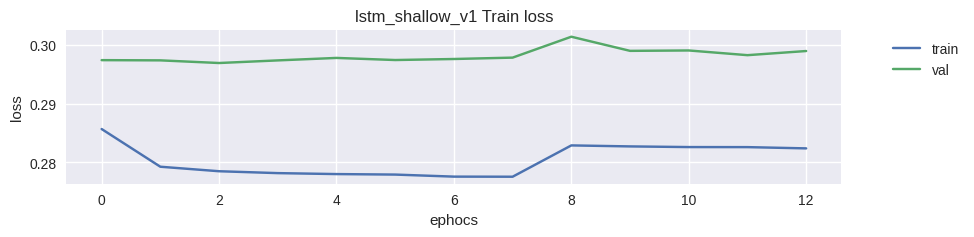

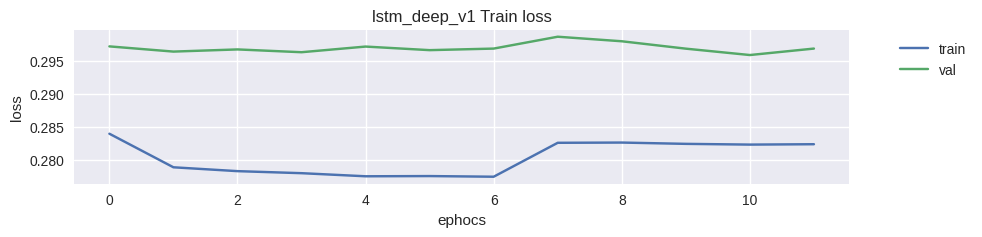

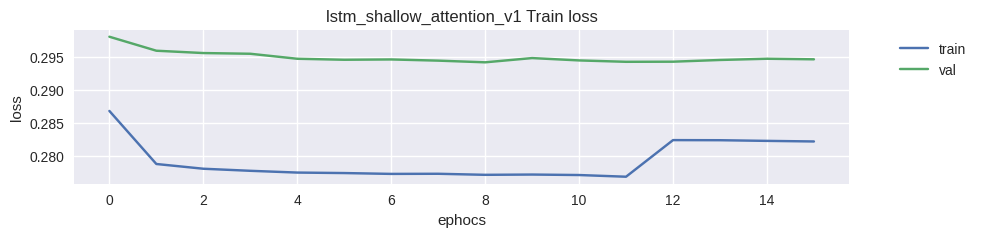

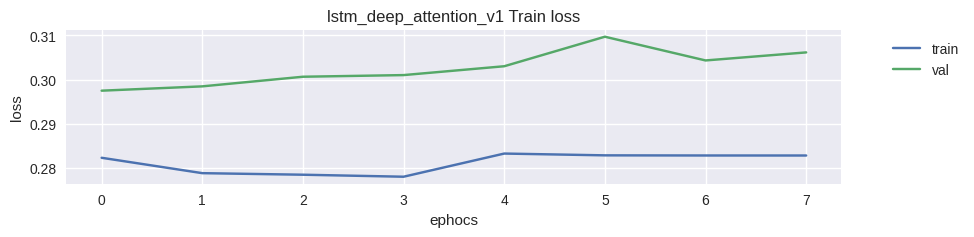

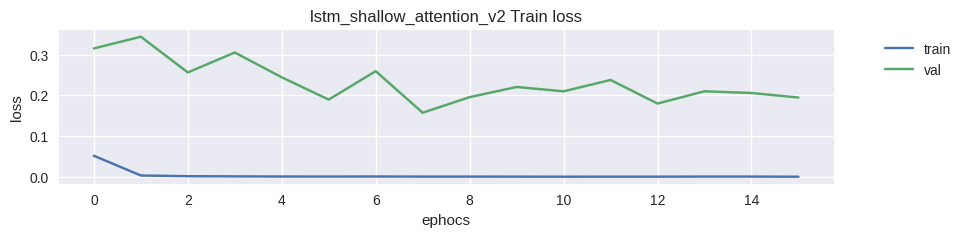

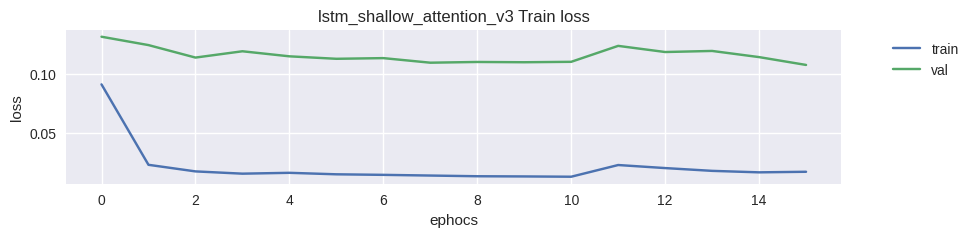

In [169]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)
    plt.show()

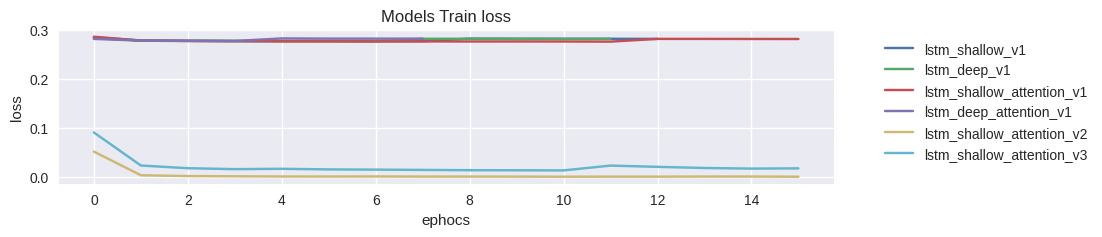

In [170]:
plt.figure(figsize=(10,2))
plt.title(f"Models Train loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)
plt.show()

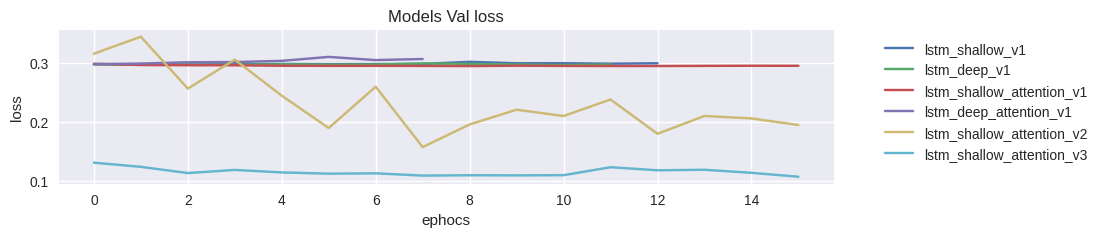

In [171]:
plt.figure(figsize=(10,2))
plt.title(f"Models Val loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)

plt.show()

# Model Eval

silhouette score

In [172]:
eval_df = []

for model in models_list:
    metric = model.metric

    # Extract embeddings
    train_embedding = model.feature_extractor_model.predict(X_train)
    val_embedding = model.feature_extractor_model.predict(X_val)
    test_embedding = model.feature_extractor_model.predict(X_test)

    # --- Silhouette score ---
    train_score = silhouette_score(train_embedding, y_encoded_train, metric=metric)
    val_score = silhouette_score(val_embedding, y_encoded_val, metric=metric)
    test_score = silhouette_score(test_embedding, y_encoded_test, metric=metric)

    # --- k-NN classification ---
    knn_3 = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn_3.fit(train_embedding, y_encoded_train)
    val_acc_3NN = accuracy_score(y_encoded_val, knn_3.predict(val_embedding))
    test_acc_3NN = accuracy_score(y_encoded_test, knn_3.predict(test_embedding))

    print(f"Model Name: {model.name}")

    eval_df.append({
        "Model Name": model.name,
        "Train Type": model.train_type,
        "Metric": metric,
        "Silhouette Score Train": train_score,
        "Silhouette Score Val": val_score,
        "Silhouette Score Test": test_score,
        "3-NN Accuracy Val": val_acc_3NN,
        "3-NN Accuracy Test": test_acc_3NN
    })

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_shallow_v1
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_deep_v1
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_shallow_attention_v1
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_deep_attention_v1
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_shallow_attention_v2
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Name: lstm_shallow_attention_v3


In [173]:
eval_df = pd.DataFrame(eval_df)

eval_df.to_csv(
    os.path.join(LOGGING_DIR_NAME, 'model_evaluation.csv'),
    index=False)

# Latent Space

In [178]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def get_plot_latent_space(feature_extractor, x_train, y_train, x_val, y_val, x_test, y_test, save_path, model_name, metric, top_n=10):
    # Get base cmap and sample top_n colors
    base_cmap = plt.colormaps.get_cmap("nipy_spectral")
    colors = base_cmap(np.linspace(0, 0.95, top_n))

    plt.figure(figsize=(15, 5))


    for i, (x_i, y_i, type_i) in enumerate(zip([x_train, x_val, x_test],
                                              [y_train, y_val, y_test],
                                              ['Train', 'Val', 'Test'])):
      # Extract features
      features = feature_extractor.predict(x_i)

      # Run t-SNE
      reducer = TSNE(n_components=2, perplexity=30, random_state=42, metric= metric)
      features_2d = reducer.fit_transform(features)

      plt.subplot(1, 3, i + 1)

      # Scatter plot per class
      for class_idx in range(top_n):
          class_mask = (y_i == class_idx)
          features_mask = features_2d[class_mask]
          plt.scatter(features_mask[:, 0],
                      features_mask[:, 1],
                      color=colors[class_idx],
                      label=f'{y_label_encoder.classes_[class_idx]}')

      if i == 2:
        # Legend
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )

      plt.title(type_i)
      plt.xlabel('Dimension 1')
      plt.ylabel('Dimension 2')
      plt.grid(True)

    plt.suptitle(f't-SNE Visualization of Latent Space {model_name}, Metric: {metric}, TOP {top_n} Classes')
    plt.savefig(save_path, dpi=300)
    plt.show()


In [179]:
for model in models_list:
    m = model.feature_extractor_model

    dir_save = os.path.join(BASE_DIR, 'latent_space')
    os.makedirs(dir_save, exist_ok=True)
    save_path = os.path.join(dir_save, f'{model.name} latent space.png')

    if os.path.exists(save_path) == True:
        print(f'Skip {model.name}, It is already in cache data')
        continue

    get_plot_latent_space(m,
                          X_train, y_encoded_train,
                          X_val, y_encoded_val,
                          X_test, y_encoded_test,
                          save_path, model.name,
                          metric = model.metric,
                          top_n = 10)

Skip lstm_shallow_v1, It is already in cache data
Skip lstm_deep_v1, It is already in cache data
Skip lstm_shallow_attention_v1, It is already in cache data
Skip lstm_deep_attention_v1, It is already in cache data
Skip lstm_shallow_attention_v2, It is already in cache data
Skip lstm_shallow_attention_v3, It is already in cache data


# Cache

In [180]:
save_obj(x_tokenizer, TOKENIZER_PATH)